# 데이터 불러오기

In [232]:
import pandas as pd
import os

pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_columns', None)

PATH = './data/서울시 상권분석서비스(오탈자 수정)/'

file_list= os.listdir(PATH)
csv_list = list()

for file in file_list:
    if file.split(".")[-1] == 'csv':
        csv_list.append(file)
data = ['rent','small_rent','big_rent','living_popul','indicator','resident_popul', 'income','apartment', 'area', 'store', 'working_popul', 'facilitie', 'estimated_sales']

for name, file in zip(data, csv_list):
    if name == 'rent':
        globals()[name] = pd.read_csv(PATH + file, names = ['기준년코드', '기준분기코드', '행정동코드', '행정동코드명', '임대시세층구분코드', '임대시세층구분명', '보증금평균','월임대료평균','환산임대료평균','임대건수'],encoding = "ansi")
    else:
        globals()[name] = pd.read_csv(PATH + file, encoding = "ansi")

store = store.drop("Unnamed: 0", axis = 1)
estimated_sales = estimated_sales.drop("Unnamed: 0", axis = 1)

# 데이터 전처리

## 시점 통일

In [233]:
years = [20223, 20224, 20231, 20232]

living_popul = living_popul[living_popul['기준_년분기_코드'].isin(years)]
resident_popul = resident_popul[resident_popul['기준_년분기_코드'].isin(years)]
store = store[store['기준_년분기_코드'].isin(years)]
working_popul = working_popul[working_popul['기준_년분기_코드'].isin(years)]
facilitie = facilitie[facilitie['기준_년분기_코드'].isin(years)]
estimated_sales = estimated_sales[estimated_sales['기준_년분기_코드'].isin(years)]

## 길단위인구 전처리

### 파생변수 생성
1.시간대_21_06_유동인구_수
  - 21_00시 유동인구의 특징과 00_06시 유동인구의 특징이 비슷하다고 생각하여 합침

2.주중_유동인구_수
  - 월~금 유동인구 수의 합

3.주말_유동인구_수
  - 토,일 유동인구 수의 합

4.30_40, 50_60대 유동인구 수 합

In [234]:
living_popul['시간대_21_06_유동인구_수'] = living_popul['시간대_00_06_유동인구_수'] + living_popul['시간대_21_24_유동인구_수']
living_popul['주중_유동인구_수'] = living_popul['월요일_유동인구_수'] + living_popul['화요일_유동인구_수'] + living_popul['수요일_유동인구_수'] + living_popul['목요일_유동인구_수'] + living_popul['금요일_유동인구_수']
living_popul['주말_유동인구_수'] = living_popul['토요일_유동인구_수'] + living_popul['일요일_유동인구_수']
living_popul['연령대_30_40_유동인구_수'] = living_popul['연령대_30_유동인구_수'] + living_popul['연령대_40_유동인구_수']
living_popul['연령대_50_60_유동인구_수'] = living_popul['연령대_50_유동인구_수'] + living_popul['연령대_60_이상_유동인구_수']

### 불필요한 feature 제거
- 상권_구분_코드
- 상권_코드
- 월~일 유동인구 수
- 21~06시 유동인구수
- 30~60대 연령

In [235]:
living_popul = living_popul.drop(['상권_구분_코드','상권_코드','월요일_유동인구_수', '화요일_유동인구_수', '수요일_유동인구_수', '목요일_유동인구_수', '금요일_유동인구_수', '토요일_유동인구_수', '일요일_유동인구_수', '시간대_00_06_유동인구_수', '시간대_21_24_유동인구_수','연령대_30_유동인구_수','연령대_40_유동인구_수','연령대_50_유동인구_수','연령대_60_이상_유동인구_수'], axis = 1)

### 결측치 확인 및 제거
- 결측치 없음

In [236]:
living_popul.isnull().sum()

기준_년분기_코드           0
상권_구분_코드_명          0
상권_코드_명             0
총_유동인구_수            0
남성_유동인구_수           0
여성_유동인구_수           0
연령대_10_유동인구_수       0
연령대_20_유동인구_수       0
시간대_06_11_유동인구_수    0
시간대_11_14_유동인구_수    0
시간대_14_17_유동인구_수    0
시간대_17_21_유동인구_수    0
시간대_21_06_유동인구_수    0
주중_유동인구_수           0
주말_유동인구_수           0
연령대_30_40_유동인구_수    0
연령대_50_60_유동인구_수    0
dtype: int64

### 이상치 확인 및 제거
- 유동인구가 적은 헌인가구단지,청계산원터골, 한국교통안전공단 강남자동차검사소 제거

In [237]:
living_popul.describe()

,기준_년분기_코드,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,연령대_10_유동인구_수,연령대_20_유동인구_수,시간대_06_11_유동인구_수,시간대_11_14_유동인구_수,시간대_14_17_유동인구_수,시간대_17_21_유동인구_수,시간대_21_06_유동인구_수,주중_유동인구_수,주말_유동인구_수,연령대_30_40_유동인구_수,연령대_50_60_유동인구_수
count,6597.000,6597.000,6597.000,6597.000,6597.000,6597.000,6597.000,6597.000,6597.000,6597.000,6597.000,6597.000,6597.000,6597.000,6597.000
mean,20227.499,831723.936,396454.429,435269.521,106249.107,148852.466,169196.692,107398.432,108468.099,144295.668,302365.121,600110.514,231613.502,281556.790,295065.647
std,4.032,900980.836,437696.274,466905.782,113447.145,216584.734,179874.328,134146.790,137040.744,167412.286,321245.522,660890.833,246084.966,332193.428,308808.842
min,20223.000,12.000,12.000,0.000,0.000,0.000,4.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,20223.000,221703.000,106884.000,113949.000,25620.000,32184.000,45807.000,28462.000,28587.000,38158.000,75590.000,159214.000,60098.000,74298.000,79315.000
50%,20224.000,568553.000,269829.000,297045.000,71540.000,82940.000,117002.000,72028.000,72359.000,96289.000,205750.000,406266.000,159173.000,185168.000,206051.000
75%,20231.000,1138476.000,537610.000,593960.000,147393.000,184525.000,234575.000,140269.000,140608.000,194982.000,417273.000,828500.000,314287.000,370667.000,412023.000
max,20232.000,8657826.000,4693188.000,4032096.000,829062.000,3487417.000,1678321.000,1853219.000,1861965.000,1793125.000,2942275.000,6833618.000,2124591.000,3506912.000,3565244.000


In [238]:
living_popul[living_popul['여성_유동인구_수'] == 0]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,연령대_10_유동인구_수,연령대_20_유동인구_수,시간대_06_11_유동인구_수,시간대_11_14_유동인구_수,시간대_14_17_유동인구_수,시간대_17_21_유동인구_수,시간대_21_06_유동인구_수,주중_유동인구_수,주말_유동인구_수,연령대_30_40_유동인구_수,연령대_50_60_유동인구_수
702,20232,골목상권,헌인가구단지,15,15,0,0,15,9,5,1,0,0,15,0,0,0
2352,20231,골목상권,청계산원터골,12,12,0,0,0,4,8,0,0,0,0,12,0,12
4000,20224,골목상권,헌인가구단지,43,43,0,0,43,14,21,8,0,0,43,0,0,0


In [239]:
area[area['상권_코드_명']=='헌인가구단지']

,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,엑스좌표_값,와이좌표_값,자치구_코드,자치구_코드_명,행정동_코드,행정동_코드_명,영역_면적
955,A,골목상권,3110948,헌인가구단지,207939,439987,11650,서초구,11650660,내곡동,198674


In [240]:
drop_list = ['헌인가구단지','청계산원터골']
living_popul = living_popul[~living_popul['상권_코드_명'].isin(drop_list)]

In [241]:
living_popul.describe()

,기준_년분기_코드,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,연령대_10_유동인구_수,연령대_20_유동인구_수,시간대_06_11_유동인구_수,시간대_11_14_유동인구_수,시간대_14_17_유동인구_수,시간대_17_21_유동인구_수,시간대_21_06_유동인구_수,주중_유동인구_수,주말_유동인구_수,연령대_30_40_유동인구_수,연령대_50_60_유동인구_수
count,6592.000,6592.000,6592.000,6592.000,6592.000,6592.000,6592.000,6592.000,6592.000,6592.000,6592.000,6592.000,6592.000,6592.000,6592.000
mean,20227.500,832354.434,396754.899,435599.550,106329.674,148965.342,169324.923,107479.822,108550.304,144405.047,302594.413,600565.445,231789.070,281770.211,295289.281
std,4.031,901031.466,437726.198,466928.964,113452.424,216628.068,179882.239,134165.090,137060.187,167428.635,321259.389,660934.890,246095.662,332228.960,308819.118
min,20223.000,2208.000,1180.000,336.000,171.000,0.000,454.000,350.000,298.000,156.000,44.000,1672.000,396.000,492.000,900.000
25%,20223.750,221944.750,107104.750,114677.500,25661.750,32221.500,45986.500,28511.500,28704.000,38284.500,75659.750,159613.000,60278.750,74720.000,79419.000
50%,20227.500,569426.000,270193.000,297292.500,71593.500,83095.500,117016.000,72188.500,72446.000,96368.500,206282.500,406605.000,159478.000,185352.000,206334.000
75%,20231.250,1139881.000,537663.250,595211.750,147670.000,184660.500,234715.000,140328.000,140697.250,195004.250,417594.000,829548.750,314400.000,370918.250,412539.750
max,20232.000,8657826.000,4693188.000,4032096.000,829062.000,3487417.000,1678321.000,1853219.000,1861965.000,1793125.000,2942275.000,6833618.000,2124591.000,3506912.000,3565244.000


In [242]:
living_popul[living_popul['연령대_20_유동인구_수'] == 0]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,연령대_10_유동인구_수,연령대_20_유동인구_수,시간대_06_11_유동인구_수,시간대_11_14_유동인구_수,시간대_14_17_유동인구_수,시간대_17_21_유동인구_수,시간대_21_06_유동인구_수,주중_유동인구_수,주말_유동인구_수,연령대_30_40_유동인구_수,연령대_50_60_유동인구_수
648,20232,골목상권,한국교통안전공단 강남자동차검사소,2232,1896,336,200,0,724,616,660,188,44,1836,396,680,1352
2297,20231,골목상권,한국교통안전공단 강남자동차검사소,2308,1904,404,448,0,644,616,736,240,72,1856,452,496,1364
3946,20224,골목상권,한국교통안전공단 강남자동차검사소,2208,1696,512,336,0,656,580,668,220,84,1672,536,492,1380


In [243]:
drop_list = ['한국교통안전공단 강남자동차검사소']
living_popul = living_popul[~living_popul['상권_코드_명'].isin(drop_list)]

In [244]:
living_popul.describe()

,기준_년분기_코드,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,연령대_10_유동인구_수,연령대_20_유동인구_수,시간대_06_11_유동인구_수,시간대_11_14_유동인구_수,시간대_14_17_유동인구_수,시간대_17_21_유동인구_수,시간대_21_06_유동인구_수,주중_유동인구_수,주말_유동인구_수,연령대_30_40_유동인구_수,연령대_50_60_유동인구_수
count,6588.000,6588.000,6588.000,6588.000,6588.000,6588.000,6588.000,6588.000,6588.000,6588.000,6588.000,6588.000,6588.000,6588.000,6588.000
mean,20227.500,832858.038,396994.531,435863.521,106393.944,149055.728,169427.274,107544.679,108615.756,144492.479,302777.924,600928.738,231929.380,281940.796,295467.643
std,4.031,901073.073,437750.989,466947.750,113456.866,216662.759,179888.862,134179.986,137076.042,167441.842,321270.542,660970.998,246104.455,332257.649,308827.987
min,20223.000,2412.000,1180.000,1086.000,171.000,57.000,454.000,350.000,298.000,156.000,544.000,1786.000,609.000,706.000,900.000
25%,20223.750,223100.250,107382.250,115069.500,25708.750,32334.250,46082.750,28561.000,28773.250,38324.250,75752.000,159978.250,60339.500,74947.750,79535.000
50%,20227.500,569686.000,270305.500,297377.000,71625.500,83144.500,117055.000,72287.500,72632.500,96502.000,206435.500,406818.500,159656.000,185386.000,206555.500
75%,20231.250,1140100.500,537673.750,595809.750,147759.000,184898.500,234930.500,140484.000,140719.250,195039.750,417619.750,830217.000,314667.750,371003.250,412783.750
max,20232.000,8657826.000,4693188.000,4032096.000,829062.000,3487417.000,1678321.000,1853219.000,1861965.000,1793125.000,2942275.000,6833618.000,2124591.000,3506912.000,3565244.000


In [245]:
living_popul[living_popul['총_유동인구_수'] > 7000000]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,연령대_10_유동인구_수,연령대_20_유동인구_수,시간대_06_11_유동인구_수,시간대_11_14_유동인구_수,시간대_14_17_유동인구_수,시간대_17_21_유동인구_수,시간대_21_06_유동인구_수,주중_유동인구_수,주말_유동인구_수,연령대_30_40_유동인구_수,연령대_50_60_유동인구_수
2,20232,관광특구,종로·청계 관광특구,8580607,4570612,4009996,322394,1490540,1678321,1815991,1823148,1715164,1547982,6823978,1756628,3274487,3493185
4,20232,관광특구,명동 남대문 북창동 다동 무교동 관광특구,7258225,3500135,3758090,304018,1221932,1528984,1820261,1785956,1355004,768020,5947399,1310825,3399606,2332669
371,20232,발달상권,강남역,7823728,3955268,3868460,769592,2195122,1476879,1408434,1453614,1726038,1758765,6132164,1691564,3431086,1427928
466,20232,발달상권,"신촌역(신촌역, 신촌로터리)",7280557,3248459,4032096,797975,3487417,1254635,1041957,1108082,1658129,2217753,5155964,2124591,1801866,1193298
1651,20231,관광특구,종로·청계 관광특구,8502972,4590859,3912112,351982,1513170,1614425,1819068,1856681,1707645,1505154,6756828,1746145,3208136,3429686
1653,20231,관광특구,명동 남대문 북창동 다동 무교동 관광특구,7334315,3588578,3745738,317233,1266022,1526756,1814899,1808164,1377142,807356,6003412,1330903,3441793,2309269
2020,20231,발달상권,강남역,7942915,4000287,3942628,816174,2253035,1455555,1429461,1491003,1793125,1773769,6236830,1706086,3433420,1440286
2642,20231,골목상권,까치산역 3번,7012938,3305441,3707497,605814,1273343,1529921,757403,731697,1051641,2942275,4900451,2112486,2669925,2463853
3300,20224,관광특구,종로·청계 관광특구,8657826,4693188,3964638,334742,1500979,1653054,1825114,1861965,1729022,1588672,6833618,1824209,3256861,3565244
3302,20224,관광특구,명동 남대문 북창동 다동 무교동 관광특구,7629595,3717728,3911867,365427,1301955,1556366,1853219,1851308,1478804,889897,6103768,1525826,3506912,2455300


### 중복행 확인 및 제거
- 중복행 없음

In [246]:
living_popul[living_popul.duplicated()]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,연령대_10_유동인구_수,연령대_20_유동인구_수,시간대_06_11_유동인구_수,시간대_11_14_유동인구_수,시간대_14_17_유동인구_수,시간대_17_21_유동인구_수,시간대_21_06_유동인구_수,주중_유동인구_수,주말_유동인구_수,연령대_30_40_유동인구_수,연령대_50_60_유동인구_수


### 분기데이터 1년치 데이터로 변환
- 유동인구 -> 4개 분기의 평균

In [247]:
living_popul_year = living_popul.groupby(['상권_구분_코드_명','상권_코드_명'],as_index=False).mean()
living_popul_year = living_popul_year.drop('기준_년분기_코드', axis = 1)

## 상주인구 전처리

### 불필요한 feature 제거
- 상권_구분_코드
- 상권_코드
- 총 상주인구 수
- 남성 상주인구 수
- 여성 상주인구 수
- 연령대 10 ~ 60 이상상주인구 수
- 총 가구 수, 아파트 가구 수, 비아파트 가구수

In [248]:
resident_popul = resident_popul[['기준_년분기_코드','상권_구분_코드_명','상권_코드_명','총_상주인구_수','남성_상주인구_수','여성_상주인구_수','연령대_10_상주인구_수','연령대_20_상주인구_수','연령대_30_상주인구_수','연령대_40_상주인구_수','연령대_50_상주인구_수','연령대_60_이상_상주인구_수']]

### 파생변수 생성

In [249]:
resident_popul['상권_구분_코드_명'].unique()

array(['골목상권', '발달상권', '전통시장', '관광특구'], dtype=object)

In [250]:
resident_popul['연령대_30_40_상주인구_수'] = resident_popul['연령대_30_상주인구_수']+resident_popul['연령대_40_상주인구_수']
resident_popul['연령대_50_60_상주인구_수'] = resident_popul['연령대_50_상주인구_수']+resident_popul['연령대_60_이상_상주인구_수']

In [251]:
resident_popul.drop(['연령대_30_상주인구_수','연령대_40_상주인구_수','연령대_50_상주인구_수','연령대_60_이상_상주인구_수'],axis=1,inplace=True)

### 결측치 확인 및 제거
- 결측치 없음

In [252]:
resident_popul.isnull().sum()

기준_년분기_코드           0
상권_구분_코드_명          0
상권_코드_명             0
총_상주인구_수            0
남성_상주인구_수           0
여성_상주인구_수           0
연령대_10_상주인구_수       0
연령대_20_상주인구_수       0
연령대_30_40_상주인구_수    0
연령대_50_60_상주인구_수    0
dtype: int64

### 이상치 확인 및 제거
- 이상치가 없다고 판단됨

In [253]:
resident_popul.describe()

,기준_년분기_코드,총_상주인구_수,남성_상주인구_수,여성_상주인구_수,연령대_10_상주인구_수,연령대_20_상주인구_수,연령대_30_40_상주인구_수,연령대_50_60_상주인구_수
count,6512.000,6512.000,6512.000,6512.000,6512.000,6512.000,6512.000,6512.000
mean,20227.495,2361.003,1166.658,1194.345,230.155,300.171,789.651,1041.026
std,4.032,2349.098,1159.233,1195.283,262.098,340.145,834.359,1031.672
min,20223.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,20223.000,656.750,328.000,329.750,52.000,70.000,207.000,281.000
50%,20224.000,1621.000,811.500,817.000,147.000,195.000,528.000,721.000
75%,20231.000,3306.250,1639.000,1677.000,318.000,413.250,1083.000,1466.000
max,20232.000,21341.000,10459.000,10882.000,3078.000,4457.000,7626.000,8342.000


### 중복행 확인 및 제거
- 중복행 없음

In [254]:
resident_popul[resident_popul.duplicated()]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,총_상주인구_수,남성_상주인구_수,여성_상주인구_수,연령대_10_상주인구_수,연령대_20_상주인구_수,연령대_30_40_상주인구_수,연령대_50_60_상주인구_수


### 분기데이터 1년치 데이터로 변환
- 마지막 분기인 2023년 2분기의 상주인구만 추출

In [255]:
resident_popul_year = resident_popul[resident_popul['기준_년분기_코드'] == 20232]
resident_popul_year = resident_popul_year.drop(['기준_년분기_코드'],axis=1)

## 점포 전처리

### 불필요한 feature 제거
- 상권_구분_코드
- 상권_코드
- 서비스_업종_코드

In [256]:
store.drop(['상권_구분_코드','상권_코드','서비스_업종_코드'],axis=1,inplace=True)

### 중복행 확인 및 제거
- 중복행 없음

In [257]:
store[store.duplicated()]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,서비스_업종_코드_명,점포_수,유사_업종_점포_수,개업_율,개업_점포_수,폐업_률,폐업_점포_수,프랜차이즈_점포_수


### 결측치 확인 및 제거
- 결측치 없음

In [258]:
store.isnull().sum()

기준_년분기_코드      0
상권_구분_코드_명     0
상권_코드_명        0
서비스_업종_코드_명    0
점포_수           0
유사_업종_점포_수     0
개업_율           0
개업_점포_수        0
폐업_률           0
폐업_점포_수        0
프랜차이즈_점포_수     0
dtype: int64

### 이상치 확인 및 제거
- 점포수 -> 8500개? 이상치 인듯?

In [259]:
store.describe()

,기준_년분기_코드,점포_수,유사_업종_점포_수,개업_율,개업_점포_수,폐업_률,폐업_점포_수,프랜차이즈_점포_수
count,304774.000,304774.000,304774.000,304774.000,304774.000,304774.000,304774.000,304774.000
mean,20227.497,6.056,6.506,2.292,0.138,2.479,0.179,0.450
std,4.031,42.503,42.878,10.900,0.615,11.805,1.158,2.232
min,20223.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,20223.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000
50%,20224.000,2.000,2.000,0.000,0.000,0.000,0.000,0.000
75%,20231.000,4.000,5.000,0.000,0.000,0.000,0.000,0.000
max,20232.000,9002.000,9018.000,200.000,29.000,400.000,288.000,127.000


In [260]:
store[store['점포_수']>1000]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,서비스_업종_코드_명,점포_수,유사_업종_점포_수,개업_율,개업_점포_수,폐업_률,폐업_점포_수,프랜차이즈_점포_수
1056166,20223,발달상권,구로역,조명용품,2190,2191,0,3,1,11,1
1059879,20223,발달상권,가락시장,청과상,1655,1655,0,5,1,9,0
1070476,20223,발달상권,가산디지털단지,전자상거래업,1207,1211,0,2,3,41,4
1077493,20223,발달상권,용산전자상가(용산역),컴퓨터및주변장치판매,1826,1828,0,8,2,32,2
1078704,20223,관광특구,동대문패션타운 관광특구,유아의류,1513,1516,0,0,4,53,3
1088295,20223,발달상권,신당역,일반의류,1749,1754,0,1,4,62,5
1098955,20223,관광특구,동대문패션타운 관광특구,일반의류,9002,9018,0,19,3,288,16
1101418,20223,전통시장,"평화시장(통일상가, 동화상가)",일반의류,1278,1282,1,11,3,42,4
1116930,20223,관광특구,명동 남대문 북창동 다동 무교동 관광특구,일반의류,2200,2202,1,20,2,47,2
1118140,20223,전통시장,"평화시장(남평화시장, 제일평화시장, 신평화패션타운)",일반의류,1908,1909,0,4,4,68,1


### 분기데이터 1년치 데이터로 변환
- 마지막 분기인 2023년 2분기의 데이터만 추출

In [261]:
store_year = store[store['기준_년분기_코드'] == 20232]
store_year = store_year.drop(columns = ['기준_년분기_코드'])

## 직장인구 전처리

### 필요한 컬럼만 추출
- 기준_년분기_코드
- 상권_구분_코드_명
- 상권_코드_명
- 총_직장_인구_수

In [262]:
working_popul = working_popul[['기준_년분기_코드', '상권_구분_코드_명', '상권_코드_명', '총_직장_인구_수']]


### 결측치 확인 및 제거
- 결측치 없음

In [263]:
working_popul.isnull().sum()

기준_년분기_코드     0
상권_구분_코드_명    0
상권_코드_명       0
총_직장_인구_수     0
dtype: int64

### 이상치 확인 및 제거
- 이상치 없음

In [264]:
working_popul.describe()

,기준_년분기_코드,총_직장_인구_수
count,6492.000,6492.000
mean,20227.500,1771.425
std,4.031,6246.210
min,20223.000,1.000
25%,20223.750,107.000
50%,20227.500,317.000
75%,20231.250,892.000
max,20232.000,104830.000


In [265]:
working_popul[working_popul['총_직장_인구_수']>60000]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,총_직장_인구_수
7062,20223,발달상권,포스코사거리,61667
7711,20223,관광특구,명동 남대문 북창동 다동 무교동 관광특구,104830
8043,20223,발달상권,가산디지털단지,81127
8083,20223,발달상권,강남역,72613
8259,20223,발달상권,여의도역(여의도),69255
8685,20224,발달상권,포스코사거리,61667
9334,20224,관광특구,명동 남대문 북창동 다동 무교동 관광특구,104830
9665,20224,발달상권,가산디지털단지,81127
9706,20224,발달상권,강남역,72613
9882,20224,발달상권,여의도역(여의도),69255


### 중복행 확인 및 제거
- 중복행 없음

In [266]:
working_popul[working_popul.duplicated()]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,총_직장_인구_수


### 분기데이터 1년치 데이터로 변환
- 마지막 분기인 2023년 2분기의 데이터만 추출

In [267]:
working_popul_year = working_popul[working_popul['기준_년분기_코드'] == 20232]
working_popul_year = working_popul_year.drop(['기준_년분기_코드'],axis=1)

## 집객시설 전처리

### 불필요한 feature 제거
- 상권_구분_코드
- 상권_코드
- 집객시설_수

In [268]:
facilitie.drop(['상권_구분_코드','상권_코드','집객시설_수','철도_역_수'],axis=1,inplace=True)

### 파생변수 생성

In [269]:
facilitie['초중고_수'] = facilitie['초등학교_수']+facilitie['중학교_수']+facilitie['고등학교_수']
facilitie.drop(['초등학교_수','중학교_수','고등학교_수'],axis=1,inplace=True)

### 결측치 확인 및 제거
- 결측치 -> 0으로 처리

In [270]:
facilitie.isnull().sum()

기준_년분기_코드        0
상권_구분_코드_명       0
상권_코드_명          0
관공서_수         3792
은행_수          4364
종합병원_수        6220
일반_병원_수       5784
약국_수          2276
유치원_수         5708
대학교_수         5976
백화점_수         6268
슈퍼마켓_수        5892
극장_수          5976
숙박_시설_수       5732
공항_수          6308
버스_터미널_수      6304
지하철_역_수       5532
버스_정거장_수      1232
초중고_수         6308
dtype: int64

In [271]:
facilitie.shape

(6312, 19)

In [272]:
facilitie = facilitie.fillna(0)
facilitie.isnull().sum()

기준_년분기_코드     0
상권_구분_코드_명    0
상권_코드_명       0
관공서_수         0
은행_수          0
종합병원_수        0
일반_병원_수       0
약국_수          0
유치원_수         0
대학교_수         0
백화점_수         0
슈퍼마켓_수        0
극장_수          0
숙박_시설_수       0
공항_수          0
버스_터미널_수      0
지하철_역_수       0
버스_정거장_수      0
초중고_수         0
dtype: int64

### 이상치 확인 및 제거
- 은행 52개 버스정거장수 85 집객 시설 수 594개 이상한데

In [273]:
facilitie.describe()

,기준_년분기_코드,관공서_수,은행_수,종합병원_수,일반_병원_수,약국_수,유치원_수,대학교_수,백화점_수,슈퍼마켓_수,극장_수,숙박_시설_수,공항_수,버스_터미널_수,지하철_역_수,버스_정거장_수,초중고_수
count,6312.000,6312.000,6312.000,6312.000,6312.000,6312.000,6312.000,6312.000,6312.000,6312.000,6312.000,6312.000,6312.000,6312.000,6312.000,6312.000,6312.000
mean,20227.500,0.695,1.015,0.015,0.107,2.359,0.112,0.087,0.008,0.102,0.072,0.213,0.003,0.001,0.176,3.896,0.003
std,4.031,1.172,3.010,0.127,0.396,4.034,0.385,0.466,0.094,0.495,0.352,1.027,0.101,0.036,0.535,4.959,0.126
min,20223.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,20223.750,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
50%,20227.500,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000
75%,20231.250,1.000,1.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000
max,20232.000,14.000,57.000,2.000,4.000,52.000,6.000,7.000,2.000,8.000,5.000,18.000,4.000,1.000,5.000,85.000,5.000


In [274]:
facilitie[facilitie['약국_수']==52]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,관공서_수,은행_수,종합병원_수,일반_병원_수,약국_수,유치원_수,대학교_수,백화점_수,슈퍼마켓_수,극장_수,숙박_시설_수,공항_수,버스_터미널_수,지하철_역_수,버스_정거장_수,초중고_수
2544,20232,발달상권,강남역,7.000,24.000,0.000,0.000,52.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,2.000,36.000,0.000
2545,20231,발달상권,강남역,7.000,24.000,0.000,0.000,52.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,2.000,36.000,0.000
14631,20224,발달상권,강남역,7.000,24.000,0.000,0.000,52.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,2.000,36.000,0.000
14632,20223,발달상권,강남역,7.000,24.000,0.000,0.000,52.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,2.000,36.000,0.000


In [275]:
facilitie[facilitie['버스_정거장_수']>80]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,관공서_수,은행_수,종합병원_수,일반_병원_수,약국_수,유치원_수,대학교_수,백화점_수,슈퍼마켓_수,극장_수,숙박_시설_수,공항_수,버스_터미널_수,지하철_역_수,버스_정거장_수,초중고_수
2386,20232,발달상권,가산디지털단지,7.000,25.000,0.000,0.000,16.000,0.000,0.000,0.000,0.000,1.000,3.000,0.000,0.000,2.000,85.000,0.000
2387,20231,발달상권,가산디지털단지,7.000,25.000,0.000,0.000,16.000,0.000,0.000,0.000,0.000,1.000,3.000,0.000,0.000,2.000,85.000,0.000
13920,20224,발달상권,가산디지털단지,7.000,25.000,0.000,0.000,16.000,0.000,0.000,0.000,0.000,1.000,3.000,0.000,0.000,2.000,85.000,0.000
13921,20223,발달상권,가산디지털단지,7.000,25.000,0.000,0.000,16.000,0.000,0.000,0.000,0.000,1.000,3.000,0.000,0.000,2.000,85.000,0.000


In [276]:
area[area['상권_코드_명']=='가산디지털단지']

,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,엑스좌표_값,와이좌표_값,자치구_코드,자치구_코드_명,행정동_코드,행정동_코드_명,영역_면적
1235,D,발달상권,3120131,가산디지털단지,189641,441969,11545,금천구,11545510,가산동,1713620


In [277]:
area[area['상권_코드_명']=='명동 남대문 북창동 다동 무교동 관광특구']

,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,엑스좌표_값,와이좌표_값,자치구_코드,자치구_코드_명,행정동_코드,행정동_코드_명,영역_면적
1645,U,관광특구,3001492,명동 남대문 북창동 다동 무교동 관광특구,198397,451614,11140,중구,11140520,소공동,983618


In [278]:
area.describe()

,상권_코드,엑스좌표_값,와이좌표_값,자치구_코드,행정동_코드,영역_면적
count,1650.000,1650.000,1650.000,1650.000,1650.000,1650.000
mean,3115221.905,198981.845,449875.452,11426.218,11426858.585,99927.952
std,10321.659,7280.721,5590.503,190.534,190548.801,118818.943
min,3001491.000,182509.000,437249.000,11110.000,11110515.000,1854.000
25%,3110407.250,192815.250,445178.500,11260.000,11260575.000,35330.000
50%,3110819.500,200096.000,449849.500,11440.000,11440590.000,71927.500
75%,3120141.750,204366.250,453563.500,11590.000,11590560.000,128147.250
max,3130327.000,215352.000,465573.000,11740.000,11740700.000,2462734.000


### 중복행 확인 및 제거
- 중복행 없음


In [279]:
facilitie[facilitie.duplicated()]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,관공서_수,은행_수,종합병원_수,일반_병원_수,약국_수,유치원_수,대학교_수,백화점_수,슈퍼마켓_수,극장_수,숙박_시설_수,공항_수,버스_터미널_수,지하철_역_수,버스_정거장_수,초중고_수


### 분기데이터 1년치 데이터로 변환
- 마지막 분기인 2023년 2분기의 데이터만 추출

In [280]:
facilitie_year = facilitie[facilitie['기준_년분기_코드'] == 20232]
facilitie_year = facilitie_year.drop(['기준_년분기_코드'],axis=1)

## 추정매출 전처리

### 파생변수 생성
1.시간대_21_06_매출_건수, 시간대_21_06_매출_금액
- 21_00시 유동인구의 특징과 00_06시 유동인구의 특징이 비슷하다고 판단함

In [281]:
estimated_sales['시간대_21~06_매출_금액'] = estimated_sales['시간대_00~06_매출_금액'] + estimated_sales['시간대_21~24_매출_금액']
estimated_sales['시간대_21~06_매출_건수'] = estimated_sales['시간대_건수~06_매출_건수'] + estimated_sales['시간대_건수~24_매출_건수']
estimated_sales['연령대_30_40_매출_금액'] = estimated_sales['연령대_30_매출_금액'] + estimated_sales['연령대_40_매출_금액']
estimated_sales['연령대_50_60_매출_금액'] = estimated_sales['연령대_50_매출_금액'] + estimated_sales['연령대_60_이상_매출_금액']
estimated_sales['연령대_30_40_매출_건수'] = estimated_sales['연령대_30_매출_건수'] + estimated_sales['연령대_40_매출_건수']
estimated_sales['연령대_50_60_매출_건수'] = estimated_sales['연령대_50_매출_건수'] + estimated_sales['연령대_60_이상_매출_건수']

### 불필요한 feature제거
- 상권_구분_코드- 
상권_코
- 서비스_업종_코드
- 21~06 매출금액, 매출건수
- 월~일 매출금액, 매출건수드

In [282]:
estimated_sales.head()

,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,주중_매출_금액,주말_매출_금액,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,토요일_매출_금액,일요일_매출_금액,시간대_00~06_매출_금액,시간대_06~11_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,시간대_17~21_매출_금액,시간대_21~24_매출_금액,남성_매출_금액,여성_매출_금액,연령대_10_매출_금액,연령대_20_매출_금액,연령대_30_매출_금액,연령대_40_매출_금액,연령대_50_매출_금액,연령대_60_이상_매출_금액,주중_매출_건수,주말_매출_건수,월요일_매출_건수,화요일_매출_건수,수요일_매출_건수,목요일_매출_건수,금요일_매출_건수,토요일_매출_건수,일요일_매출_건수,시간대_건수~06_매출_건수,시간대_건수~11_매출_건수,시간대_건수~14_매출_건수,시간대_건수~17_매출_건수,시간대_건수~21_매출_건수,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,시간대_21~06_매출_금액,시간대_21~06_매출_건수,연령대_30_40_매출_금액,연령대_50_60_매출_금액,연령대_30_40_매출_건수,연령대_50_60_매출_건수
119954,20223,A,골목상권,3110001,이북5도청사,CS100001,한식음식점,476192500.000,12144,272246965.000,203945535.000,50220967.000,41484671.000,51231016.000,60876969.000,68433342.000,89976886.000,113968649.000,2309591.000,8123561.000,173947607.000,80648997.000,189908868.000,21253876,238780663.000,136290929.000,350594,10282632,42435705.000,69527464.000,107311973.000,145163223.000,7870,4274,1445,1220,1613,1746,1846,1998,2276,18,196,5573,2074,4003,280,6781,3567,11,402,1208,1823,2984,3919,23563467.000,298,111963169.000,252475196.000,3031,6903
119955,20223,A,골목상권,3110001,이북5도청사,CS100008,분식전문점,131733340.000,12582,80115318.000,51618022.000,15863778.000,14402592.000,17043418.000,17439349.000,15366181.000,29479532.000,22138490.000,425323.000,53409675.000,50806874.000,15250576.000,11840892.000,0,64040993.000,49100941.000,864318,5695062,13032855.000,31042995.000,35106850.000,27399855.000,7730,4852,1533,1483,1618,1658,1438,2654,2198,35,5125,4883,1685,854,0,6626,4743,79,612,1289,2840,3778,2769,425323.000,35,44075850.000,62506705.000,4129,6547
119956,20223,A,골목상권,3110001,이북5도청사,CS100009,호프-간이주점,26733385.000,311,12411483.000,14321902.000,1354530.000,0.000,4209920.000,2953648.000,3893385.000,10435369.000,3886533.000,7522190.000,0.000,0.000,132870.000,6194865.000,12883460,16839540.000,1751832.000,0,336604,955901.000,2106754.000,6053408.000,9138705.000,150,161,14,0,33,39,64,98,63,55,0,0,9,116,131,233,50,0,9,20,41,80,134,20405650.000,186,3062655.000,15192113.000,61,214
119957,20223,A,골목상권,3110001,이북5도청사,CS200001,일반교습학원,30274954.000,104,30274954.000,0.000,11041641.000,7435395.000,0.000,9552970.000,2244948.000,0.000,0.000,0.000,0.000,0.000,13764237.000,16510717.000,0,18954684.000,11320270.000,0,0,6957747.000,23317207.000,0.000,0.000,104,0,40,24,0,32,8,0,0,0,0,0,48,56,0,64,40,0,0,24,80,0,0,0.000,0,30274954.000,0.000,104,0
119958,20223,A,골목상권,3110002,독립문역 1번,CS100001,한식음식점,448323785.000,18519,360784328.000,87539457.000,65934976.000,73481115.000,72663559.000,76930395.000,71774283.000,71197414.000,16342043.000,3142226.000,9577302.000,219968213.000,54657271.000,140769850.000,20208923,231220733.000,181217404.000,417841,23589548,58169153.000,85203637.000,113835783.000,131222176.000,15360,3159,3033,3119,3089,3018,3101,2372,787,110,413,10022,2628,4665,681,9816,7895,57,1269,2087,3469,5430,5395,23351149.000,791,143372790.000,245057959.000,5556,10825


In [283]:
estimated_sales = estimated_sales.drop(columns = ['상권_구분_코드', '상권_코드', '서비스_업종_코드'],
                                       axis = 1)
estimated_sales = estimated_sales.drop(columns = ['월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액',
                                                  '월요일_매출_건수', '화요일_매출_건수', '수요일_매출_건수', '목요일_매출_건수', '금요일_매출_건수', '토요일_매출_건수', '일요일_매출_건수'],
                                       axis = 1)
estimated_sales = estimated_sales.drop(columns = ['시간대_00~06_매출_금액', '시간대_21~24_매출_금액', '시간대_건수~06_매출_건수', '시간대_건수~24_매출_건수',
                                                 '연령대_30_매출_금액','연령대_40_매출_금액','연령대_50_매출_금액','연령대_60_이상_매출_금액',
                                                 '연령대_30_매출_건수','연령대_40_매출_건수','연령대_50_매출_건수','연령대_60_이상_매출_건수'],
                                       axis = 1)

### 결측치 확인 및 제거
- 결측치 어떻게 처리하지

In [284]:
estimated_sales.isnull().sum()

기준_년분기_코드          0
상권_구분_코드_명         0
상권_코드_명            0
서비스_업종_코드_명        0
당월_매출_금액           0
당월_매출_건수           0
주중_매출_금액           0
주말_매출_금액           0
시간대_06~11_매출_금액    0
시간대_11~14_매출_금액    0
시간대_14~17_매출_금액    0
시간대_17~21_매출_금액    0
남성_매출_금액           0
여성_매출_금액           0
연령대_10_매출_금액       0
연령대_20_매출_금액       0
주중_매출_건수           0
주말_매출_건수           0
시간대_건수~11_매출_건수    0
시간대_건수~14_매출_건수    0
시간대_건수~17_매출_건수    0
시간대_건수~21_매출_건수    0
남성_매출_건수           0
여성_매출_건수           0
연령대_10_매출_건수       0
연령대_20_매출_건수       0
시간대_21~06_매출_금액    0
시간대_21~06_매출_건수    0
연령대_30_40_매출_금액    0
연령대_50_60_매출_금액    0
연령대_30_40_매출_건수    0
연령대_50_60_매출_건수    0
dtype: int64

### 이상치 확인 및 제거
- 당원매출금액 천억 이상치인듯

In [285]:
estimated_sales.describe()

,기준_년분기_코드,당월_매출_금액,당월_매출_건수,주중_매출_금액,주말_매출_금액,시간대_06~11_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,시간대_17~21_매출_금액,남성_매출_금액,여성_매출_금액,연령대_10_매출_금액,연령대_20_매출_금액,주중_매출_건수,주말_매출_건수,시간대_건수~11_매출_건수,시간대_건수~14_매출_건수,시간대_건수~17_매출_건수,시간대_건수~21_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,시간대_21~06_매출_금액,시간대_21~06_매출_건수,연령대_30_40_매출_금액,연령대_50_60_매출_금액,연령대_30_40_매출_건수,연령대_50_60_매출_건수
count,84143.000,84143.000,84143.000,84143.000,84143.000,84143.000,84143.000,84143.000,84143.000,84143.000,84143.000,84143.000,84143.000,84143.000,84143.000,84143.000,84143.000,84143.000,84143.000,84143.000,84143.000,84143.000,84143.000,84143.000,84143.000,84143.000,84143.000,84143.000,84143.000
mean,20227.506,1116599271.468,39184.849,842969184.583,273630043.386,116413408.602,286186909.051,280424841.016,306646276.190,506115717.968,483588097.551,5734552.208,135382675.504,29499.636,9685.213,5416.564,10204.191,8307.715,10443.374,19337.490,18168.507,577.372,7898.857,126927760.944,4813.006,431464849.292,417119530.685,16555.601,12474.165
std,4.031,9371981938.469,168454.273,6458423614.170,3509552781.251,1172352096.256,2477461950.285,3124214644.465,2771104568.472,4449083121.756,3616311150.276,31894990.608,909570386.425,117929.298,57711.259,29263.631,45978.917,44186.686,47735.342,83502.247,83244.346,3617.461,42063.066,1000325381.326,23992.316,3469029992.731,3773146796.252,73433.475,61385.401
min,20223.000,12.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,20224.000,48560077.000,868.000,36205605.500,7456979.500,145574.500,5491691.000,7869005.500,11816467.500,19597595.500,18111528.500,0.000,1369387.500,654.000,153.000,7.000,109.000,173.000,226.000,390.000,342.000,0.000,43.000,0.000,0.000,15857293.000,15467433.000,324.000,297.000
50%,20231.000,188164542.000,4646.000,140846234.000,38302621.000,6268042.000,34963031.000,36234148.000,50583967.000,84295031.000,75951653.000,166368.000,12428462.000,3446.000,1036.000,169.000,985.000,983.000,1304.000,2286.000,1968.000,12.000,446.000,4061538.000,77.000,69746034.000,63905807.000,1783.000,1642.000
75%,20232.000,686193977.000,25492.500,520555159.000,150576100.000,48504462.500,153603359.000,143040793.500,186412033.000,314344883.500,290361639.500,2273891.500,64077848.500,19055.500,5839.500,1996.000,6405.500,5206.500,6992.500,12096.000,11579.000,174.000,3306.000,51155789.000,1497.000,260456794.500,241524127.500,9897.000,8588.000
max,20232.000,995677000000.000,12090273.000,669799000000.000,485357000000.000,107916000000.000,242249000000.000,326543000000.000,386343000000.000,537243000000.000,304162000000.000,1549259735.000,90669553834.000,5827863.000,6262410.000,1474148.000,2611826.000,3245770.000,4287338.000,6708993.000,4615812.000,329040.000,3087414.000,126314287024.000,1514884.000,354347000000.000,411544000000.000,4519958.000,5329793.000


In [286]:
estimated_sales[estimated_sales['당월_매출_금액']>100000000000]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,주중_매출_금액,주말_매출_금액,시간대_06~11_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,시간대_17~21_매출_금액,남성_매출_금액,여성_매출_금액,연령대_10_매출_금액,연령대_20_매출_금액,주중_매출_건수,주말_매출_건수,시간대_건수~11_매출_건수,시간대_건수~14_매출_건수,시간대_건수~17_매출_건수,시간대_건수~21_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,시간대_21~06_매출_금액,시간대_21~06_매출_건수,연령대_30_40_매출_금액,연령대_50_60_매출_금액,연령대_30_40_매출_건수,연령대_50_60_매출_건수
130535,20223,발달상권,종로3가역,시계및귀금속,151424000000.000,316035,116073000000.000,35351442522.000,9099216558.000,47044938711.000,60743362663.000,34078980702.000,73269171958.000,64985227705.000,190340301,12385140243,261539,54496,18599,96412,136305,64295,134464,140511,1501,45115,457729637.000,424,60404443583.000,65119457763.000,126642,101461
131219,20223,발달상권,용산전자상가(용산역),컴퓨터및주변장치판매,645316000000.000,1535618,586331000000.000,58984608412.000,89246617589.000,185531000000.000,276137000000.000,93995544554.000,258986000000.000,87958653014.000,545065326,26253345353,1317689,217929,181429,500703,625583,227416,862720,262291,9143,181610,405162362.000,487,171131687184.000,149015263473.000,486962,447292
131229,20223,발달상권,용산전자상가(용산역),가전제품,177722000000.000,486081,110914000000.000,66807776593.000,8350733567.000,50217680656.000,65051714720.000,53772220714.000,95303157571.000,81354121560.000,41339507,7401544551,297410,188671,25749,124781,168960,164127,279465,203130,464,30812,329357857.000,2464,75309935660.000,93904459413.000,205395,245922
133730,20223,발달상권,구로역,조명용품,104741000000.000,251304,104303000000.000,437670248.000,21380068019.000,45504740705.000,29057994037.000,8796986879.000,64182120018.000,21510527819.000,758442,318845236,245124,6180,58408,82923,93204,16729,132936,32245,83,3358,1360916.000,40,29331963083.000,56041081077.000,48793,112949
133908,20223,발달상권,가산디지털단지,일반의류,489413000000.000,8016058,250030000000.000,239383000000.000,5470546279.000,125735000000.000,190488000000.000,163748000000.000,218028000000.000,271211000000.000,930084307,54923520493,4293306,3722752,107381,2137109,2962725,2722676,3396666,4615812,28853,1138980,3970964001.000,86167,247804000000.000,185580604531.000,4173527,2671117
134480,20223,발달상권,노량진역(노량진),수산물판매,650584000000.000,8216819,368848000000.000,281735000000.000,97457809658.000,137903000000.000,155159000000.000,221786000000.000,352703000000.000,217264000000.000,369960868,45449249234,4547037,3669782,1208160,1830568,2077374,2673179,4623841,2977903,6594,691109,38278509611.000,427538,227394000000.000,296755000000.000,2894666,4009373
135573,20223,발달상권,강남역,일반의원,115220000000.000,417496,97983839980.000,17235760729.000,25633681490.000,37060894653.000,36447090398.000,16000623938.000,39081596387.000,76131654433.000,343263540,31484513034,357887,59609,61958,126957,137420,90753,142577,274899,2325,116505,77310230.000,408,49967034925.000,33418439322.000,188834,109812
136693,20223,발달상권,삼성역,일반의류,101379000000.000,1229874,65136814853.000,36241915159.000,1218867333.000,22791870026.000,34969357163.000,37786089760.000,28238995295.000,73079392665.000,697568792,19713262075,790221,439653,16625,246085,381701,503538,322683,907052,11867,287764,4612545730.000,81925,52295846293.000,28611710799.000,660122,269982
136857,20223,발달상권,잠실역,일반의류,182855000000.000,5541923,111274000000.000,71580867786.000,1399621148.000,38501602648.000,58789169906.000,70837587717.000,63753716082.000,119073000000.000,1314007248,42248542349,3362128,2179795,53927,1060430,1765817,2236475,1697975,3843891,107241,1756957,13327152222.000,425274,98229350174.000,41034827675.000,2648917,1028751
136978,20223,발달상권,가락시장,육류판매,125980000000.000,1058237,95554982350.000,30425011671.000,27841706498.000,31173162796.000,28514577774.000,17251056541.000,54368931461.000,43439350988.000,31820109,3830981816,795803,262434,263314,225570,252503,163582,509783,429637,439,44160,21199490412.000,153268,34262794825.000,59682685700.000,336929,557891


### 중복행 확인 및 제거
- 중복행 없음

In [287]:
estimated_sales[estimated_sales.duplicated()]

,기준_년분기_코드,상권_구분_코드_명,상권_코드_명,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,주중_매출_금액,주말_매출_금액,시간대_06~11_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,시간대_17~21_매출_금액,남성_매출_금액,여성_매출_금액,연령대_10_매출_금액,연령대_20_매출_금액,주중_매출_건수,주말_매출_건수,시간대_건수~11_매출_건수,시간대_건수~14_매출_건수,시간대_건수~17_매출_건수,시간대_건수~21_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,시간대_21~06_매출_금액,시간대_21~06_매출_건수,연령대_30_40_매출_금액,연령대_50_60_매출_금액,연령대_30_40_매출_건수,연령대_50_60_매출_건수


### feature순서 재배치

In [ ]:
# cols_1 = ['기준_년분기_코드', '상권_구분_코드_명', '상권_코드_명', '서비스_업종_코드_명']

# cols_2 = ['당월_매출_금액', '주중_매출_금액', '주말_매출_금액',
#          '시간대_06~11_매출_금액', '시간대_11~14_매출_금액', '시간대_14~17_매출_금액', '시간대_17~21_매출_금액', '시간대_21~06_매출_금액',
#          '남성_매출_금액', '여성_매출_금액', 
#          '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액', '연령대_50_매출_금액', '연령대_60_이상_매출_금액']

# cols_3 = ['당월_매출_건수', '주중_매출_건수', '주말_매출_건수',
#          '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수', '시간대_건수~21_매출_건수', '시간대_21~06_매출_건수',
#          '남성_매출_건수', '여성_매출_건수',
#          '연령대_10_매출_건수', '연령대_20_매출_건수', '연령대_30_매출_건수', '연령대_40_매출_건수', '연령대_50_매출_건수', '연령대_60_이상_매출_건수']

# cols_4 = ['당월_건당_매출_금액', '주중_건당_매출_금액', '주말_건당_매출_금액',
#          '시간대_06~11_건당_매출_금액', '시간대_11~14_건당_매출_금액', '시간대_14~17_건당_매출_금액', '시간대_17~21_건당_매출_금액', '시간대_21~06_건당_매출_금액',
#          '남성_건당_매출_금액', '여성_건당_매출_금액',
#          '연령대_10_건당_매출_금액', '연령대_20_건당_매출_금액', '연령대_30_건당_매출_금액', '연령대_40_건당_매출_금액', '연령대_50_건당_매출_금액', '연령대_60_이상_건당_매출_금액']

# cols = [*cols_1, *cols_2, *cols_3, *cols_4]

# estimated_sales = estimated_sales[cols].rename(columns = {'시간대_건수~11_매출_건수' : '시간대_06~11_매출_건수',
#                                                          '시간대_건수~14_매출_건수' : '시간대_11~14_매출_건수',
#                                                          '시간대_건수~17_매출_건수' : '시간대_14~17_매출_건수',
#                                                          '시간대_건수~21_매출_건수' : '시간대_17~21_매출_건수'})

### 분기데이터 1년치 데이터로 변환

In [288]:
estimated_sales_year = estimated_sales.drop(columns = ['기준_년분기_코드']).groupby(['상권_구분_코드_명', '상권_코드_명', '서비스_업종_코드_명']).mean().reset_index()

## 임대료 전처리

### 불필요한 feature 제거
- 행정동코드
- 임대시세층구분코드
- 기준년코드
- 기준분기코드
- 임대건수
- 환산임대료평균

In [96]:
rent = rent.rename(columns = {"행정동코드명" : "행정동_코드_명"}).drop(columns = ['행정동코드', '임대시세층구분코드', '기준년코드', '기준분기코드', '임대건수', '환산임대료평균'])[rent['임대시세층구분명'] != '전체층']

In [97]:
rent.head()

,행정동_코드_명,임대시세층구분명,보증금평균,월임대료평균
0,내곡동,1층,3286492,124345
1,내곡동,1층외,17778757,110169
3,방배3동,1층외,3590641,92720
5,방배3동,1층,1093228,94289
6,삼성2동,1층외,1312205,164525


### 결측치 확인 및 제거
- 결측치 없음

In [100]:
rent.isnull().sum()

행정동_코드_명    0
임대시세층구분명    0
보증금평균       0
월임대료평균      0
dtype: int64

### 이상치 처리

In [101]:
rent.describe()

,보증금평균,월임대료평균
count,849.000,849.000
mean,2290233.134,104758.296
std,1368703.396,54340.249
min,0.000,0.000
25%,1466278.000,66164.000
50%,2003512.000,98072.000
75%,2817322.000,130993.000
max,17778757.000,424738.000


In [33]:
rent[rent['보증금평균']==0]

,기준년코드,기준분기코드,행정동코드,행정동코드명,임대시세층구분코드,임대시세층구분명,보증금평균,월임대료평균,환산임대료평균,임대건수
11,2022,4,11545700,시흥제4동,2,1층외,0,0,0,4
37,2022,4,11710720,잠실7동,1,1층,0,0,0,2
38,2022,4,11710720,잠실7동,0,전체층,0,0,0,5
39,2022,4,11710720,잠실7동,2,1층외,0,0,0,3
49,2022,4,11710690,잠실4동,0,전체층,0,0,0,8
51,2022,4,11710690,잠실4동,1,1층,0,0,0,3
92,2022,4,11200580,응봉동,0,전체층,0,0,0,10
93,2022,4,11200580,응봉동,1,1층,0,0,0,4
419,2022,4,11290580,돈암제1동,0,전체층,0,0,0,12
420,2022,4,11290580,돈암제1동,2,1층외,0,0,0,4


<Axes: >

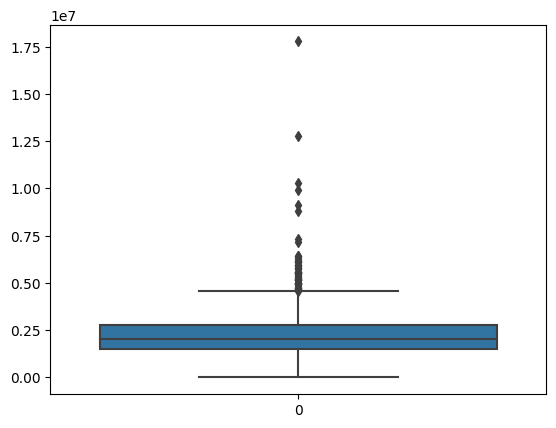

In [36]:
import seaborn as sns
sns.boxplot(rent['보증금평균'])

## 데이터 병합

In [228]:
df = pd.merge(living_popul_year, resident_popul_year)
df = pd.merge(df, area)
df = pd.merge(df, store_year)
df = pd.merge(df, working_popul_year)
df = pd.merge(df, facilitie_year)
df = pd.merge(df, estimated_sales_year)

In [229]:
# cols_1 = ['자치구_코드_명', '행정동_코드_명', '임대시세층구분명', '보증금평균', '월임대료평균']
cols_2 = ['상권_구분_코드_명', '상권_코드_명', '영역_면적', '엑스좌표_값', '와이좌표_값','자치구_코드_명','행정동_코드_명']
cols_3 = ['총_유동인구_수', '남성_유동인구_수', '여성_유동인구_수',
          '연령대_10_유동인구_수', '연령대_20_유동인구_수', '연령대_30_유동인구_수', '연령대_40_유동인구_수', '연령대_50_유동인구_수', '연령대_60_이상_유동인구_수',
          '시간대_06_11_유동인구_수', '시간대_11_14_유동인구_수', '시간대_14_17_유동인구_수', '시간대_17_21_유동인구_수', '시간대_21_06_유동인구_수',
          '주중_유동인구_수', '주말_유동인구_수']
cols_4 = ['남성연령대_10_상주인구_수', '남성연령대_20_상주인구_수', '남성연령대_30_상주인구_수', '남성연령대_40_상주인구_수', '남성연령대_50_상주인구_수', '남성연령대_60_이상_상주인구_수', 
          '여성연령대_10_상주인구_수', '여성연령대_20_상주인구_수', '여성연령대_30_상주인구_수', '여성연령대_40_상주인구_수', '여성연령대_50_상주인구_수', '여성연령대_60_이상_상주인구_수',
          '총_직장_인구_수']
cols_5 = ['관공서_수', '은행_수', '종합병원_수', '일반_병원_수', '약국_수', '유치원_수', '초등학교_수', '중학교_수', '고등학교_수',
          '대학교_수', '백화점_수', '슈퍼마켓_수', '극장_수', '숙박_시설_수', '공항_수', '철도_역_수', '버스_터미널_수', '지하철_역_수', '버스_정거장_수']
cols_6 = ['서비스_업종_코드_명', '점포_수', '유사_업종_점포_수', '개업_율', '개업_점포_수', '폐업_률', '폐업_점포_수', '프랜차이즈_점포_수']
cols_7 = ['당월_매출_금액', '주중_매출_금액', '주말_매출_금액', 
          '시간대_06~11_매출_금액', '시간대_11~14_매출_금액', '시간대_14~17_매출_금액', '시간대_17~21_매출_금액', '시간대_21~06_매출_금액', 
          '남성_매출_금액', '여성_매출_금액', 
          '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액', '연령대_50_매출_금액', '연령대_60_이상_매출_금액', 
          '당월_매출_건수', '주중_매출_건수', '주말_매출_건수', 
          '시간대_06~11_매출_건수', '시간대_11~14_매출_건수', '시간대_14~17_매출_건수', '시간대_17~21_매출_건수', '시간대_21~06_매출_건수', 
          '남성_매출_건수', '여성_매출_건수', 
          '연령대_10_매출_건수', '연령대_20_매출_건수', '연령대_30_매출_건수', '연령대_40_매출_건수', '연령대_50_매출_건수', '연령대_60_이상_매출_건수', 
          '당월_건당_매출_금액', '주중_건당_매출_금액', '주말_건당_매출_금액', 
          '시간대_06~11_건당_매출_금액', '시간대_11~14_건당_매출_금액', '시간대_14~17_건당_매출_금액', '시간대_17~21_건당_매출_금액', '시간대_21~06_건당_매출_금액', 
          '남성_건당_매출_금액', '여성_건당_매출_금액', 
          '연령대_10_건당_매출_금액', '연령대_20_건당_매출_금액', '연령대_30_건당_매출_금액', '연령대_40_건당_매출_금액', '연령대_50_건당_매출_금액', '연령대_60_이상_건당_매출_금액']


cols = [*cols_2, *cols_3, *cols_4, *cols_5, *cols_6, *cols_7]

df = df[cols]

In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26970 entries, 0 to 26969
Columns: 114 entries, 자치구_코드_명 to 월임대료평균
dtypes: float64(83), int64(25), object(6)
memory usage: 23.5+ MB


In [231]:
df.head()

,자치구_코드_명,행정동_코드_명,상권_구분_코드_명,상권_코드_명,영역_면적,엑스좌표_값,와이좌표_값,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,연령대_10_유동인구_수,연령대_20_유동인구_수,연령대_30_유동인구_수,연령대_40_유동인구_수,연령대_50_유동인구_수,연령대_60_이상_유동인구_수,시간대_06_11_유동인구_수,시간대_11_14_유동인구_수,시간대_14_17_유동인구_수,시간대_17_21_유동인구_수,시간대_21_06_유동인구_수,주중_유동인구_수,주말_유동인구_수,남성연령대_10_상주인구_수,남성연령대_20_상주인구_수,남성연령대_30_상주인구_수,남성연령대_40_상주인구_수,남성연령대_50_상주인구_수,남성연령대_60_이상_상주인구_수,여성연령대_10_상주인구_수,여성연령대_20_상주인구_수,여성연령대_30_상주인구_수,여성연령대_40_상주인구_수,여성연령대_50_상주인구_수,여성연령대_60_이상_상주인구_수,총_직장_인구_수,관공서_수,은행_수,종합병원_수,일반_병원_수,약국_수,유치원_수,초등학교_수,중학교_수,고등학교_수,대학교_수,백화점_수,슈퍼마켓_수,극장_수,숙박_시설_수,공항_수,철도_역_수,버스_터미널_수,지하철_역_수,버스_정거장_수,서비스_업종_코드_명,점포_수,유사_업종_점포_수,개업_율,개업_점포_수,폐업_률,폐업_점포_수,프랜차이즈_점포_수,당월_매출_금액,주중_매출_금액,주말_매출_금액,시간대_06~11_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,시간대_17~21_매출_금액,시간대_21~06_매출_금액,남성_매출_금액,여성_매출_금액,연령대_10_매출_금액,연령대_20_매출_금액,연령대_30_매출_금액,연령대_40_매출_금액,연령대_50_매출_금액,연령대_60_이상_매출_금액,당월_매출_건수,주중_매출_건수,주말_매출_건수,시간대_06~11_매출_건수,시간대_11~14_매출_건수,시간대_14~17_매출_건수,시간대_17~21_매출_건수,시간대_21~06_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,당월_건당_매출_금액,주중_건당_매출_금액,주말_건당_매출_금액,시간대_06~11_건당_매출_금액,시간대_11~14_건당_매출_금액,시간대_14~17_건당_매출_금액,시간대_17~21_건당_매출_금액,시간대_21~06_건당_매출_금액,남성_건당_매출_금액,여성_건당_매출_금액,연령대_10_건당_매출_금액,연령대_20_건당_매출_금액,연령대_30_건당_매출_금액,연령대_40_건당_매출_금액,연령대_50_건당_매출_금액,연령대_60_이상_건당_매출_금액,임대시세층구분명,보증금평균,월임대료평균
0,강북구,우이동,골목상권,4.19민주묘지역 2번,60794,201112,461090,868030.000,361490.250,506539.250,128381.000,163223.250,107811.500,113781.750,121303.500,233529.500,169905.000,105148.000,103902.500,145960.750,343114.000,619012.250,249017.500,73,57,62,93,95,216,62,64,72,97,95,261,96,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,한식음식점,23,24,8,2,4,1,1,1739897842.000,1033559973.000,706337869.000,34758423.750,481068145.750,310010178.000,724466602.750,189594491.750,989044375.250,651314594.250,5154289.250,116807695.250,212122359.000,294670997.500,521347174.250,490256455.000,51956.500,33236.750,18719.750,1961.250,17455.500,10006.500,18257.750,4275.500,29305.250,21307.250,335.500,5561.500,6832.000,9084.250,14829.250,13972.000,33572.889,31134.794,37937.946,17773.801,27381.008,31010.383,39874.189,44545.446,33800.232,30709.071,15353.105,21074.157,31275.325,32766.235,35019.042,35398.899,1층외,814856,35822
1,강북구,우이동,골목상권,4.19민주묘지역 2번,60794,201112,461090,868030.000,361490.250,506539.250,128381.000,163223.250,107811.500,113781.750,121303.500,233529.500,169905.000,105148.000,103902.500,145960.750,343114.000,619012.250,249017.500,73,57,62,93,95,216,62,64,72,97,95,261,96,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,한식음식점,23,24,8,2,4,1,1,1739897842.000,1033559973.000,706337869.000,34758423.750,481068145.750,310010178.000,724466602.750,189594491.750,989044375.250,651314594.250,5154289.250,116807695.250,212122359.000,294670997.500,521347174.250,490256455.000,51956.500,33236.750,18719.750,1961.250,17455.500,10006.500,18257.750,4275.500,29305.250,21307.250,335.500,5561.500,6832.000,9084.250,14829.250,13972.000,33572.889,31134.794,37937.946,17773.801,27381.008,31010.383,39874.189,44545.446,33800.232,30709.071,15353.105,21074.157,31275.325,32766.235,35019.042,35398.899,1층,1600781,74305
2,강북구,우이동,골목상권,4.19민주묘지역 2번,60794,201112,461090,868030.000,361490.250,506539.250,128381.000,163223.250,107811.500,113781.750,121303.500,233529.500,169905.000,105148.000,103902.500,145960.750,343114.000,619012.250,249017.500,73,57,62,93,95,216,62,64,72,97,95,261,96,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,일식음식점,3,3,0,0,0,0,0,18435727.000,15543098.250,2892628.750,0.000,9658447.500,3074001.750,5623422.500,79855.250,7005386.750,11430340.250,561557.250,6405609.500,2608330.250,3453367.250,3140322.750,2266540.000,1519.250,1359.250,160.000,0.000,821.500,247.000,441.750,9.000,463.250,1056.000,55.250,601.250,198.500,296.750,264.000,103.500,12216.994,1151